# Motivation
This notebook quickly explores the scenario of estimating multiple targets with the same network

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import sys
root = Path().resolve().parents[0]

if str(root) not in sys.path:
    sys.path = [str(root)] + sys.path
    print(f"Path updated with: {root}.")
    
%load_ext autoreload
%autoreload 2

Path updated with: /Users/giovanniganzinotti/repos/pytorch-azure.


In [3]:
import torch
import torch.nn as nn

In [4]:
def get_cuda_summary(memory=False):
    import torch
    
    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')

In [5]:
get_cuda_summary()

cuda is not available


# dgp

In [6]:
ranseed = 16
np.random.seed(ranseed)

In [7]:
n = 116_067

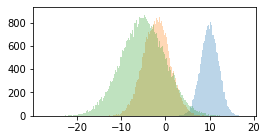

In [8]:
# features
num_var_1 = np.random.normal(loc=10, scale=2, size=n)
num_var_2 = np.random.normal(loc=-2, scale=3, size=n)
num_var_3 = np.random.normal(loc=-5, scale=5, size=n)

fig, ax = plt.subplots(figsize=(4, 2))
for var in (num_var_1, num_var_2, num_var_3):
    ax = plt.hist(var, bins=500, alpha=0.3)
plt.show()

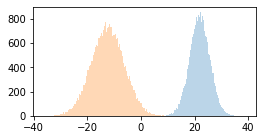

In [9]:
target_1 = 20 + 0.6 * num_var_1 + 0.8 * num_var_2 + 0.5 * num_var_3 + np.random.normal(loc=0, scale=1, size=n)
target_2 = -10 + 0.3 * num_var_1 + 0.7 * num_var_2 + 0.8 * num_var_3 + np.random.normal(loc=0, scale=4, size=n)

fig, ax = plt.subplots(figsize=(4, 2))
for var in (target_1, target_2):
    ax = plt.hist(var, bins=500, alpha=0.3)
plt.show()

# constants

In [10]:
device = torch.device('cpu')

num_inputs = 3
lin_layer_sizes = [256, 128, 64, 32]
loss_weights = [0.7, 0.3]
num_outputs = len(loss_weights)

batch_size = 512
learning_rate = 0.001

num_epochs = 2_000
n_epochs_stop = 50

model_path = '../models/multiple_outputs_model_checkpoint.pth'

# data prep

In [11]:
x = np.concatenate((
    num_var_1.reshape(-1, 1), 
    num_var_2.reshape(-1, 1), 
    num_var_3.reshape(-1, 1),
), axis=1)
x.shape

y = np.concatenate((
    target_1.reshape(-1, 1), 
    target_2.reshape(-1, 1), 
), axis=1)
y.shape

(116067, 2)

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(87050, 3) (87050, 2)
(29017, 3) (29017, 2)


In [13]:
def return_dataset_and_loader(x, y, batch_size: int = 32, shuffle: bool = True):
    dataset = torch.utils.data.TensorDataset(
        torch.from_numpy(x).float(),
        torch.from_numpy(y).float(),
    )

    loader = torch.utils.data.DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=shuffle,
    )
    
    return dataset, loader

train_dataset, train_loader = return_dataset_and_loader(
    x_train, y_train, batch_size=batch_size, shuffle=True
)

test_dataset, test_loader = return_dataset_and_loader(
    x_test, y_test, batch_size=len(x_test), shuffle=False
)

for feature, target in test_loader:
    print(feature.shape, target.shape)
    print(feature.dtype, target.dtype)

torch.Size([29017, 3]) torch.Size([29017, 2])
torch.float32 torch.float32


# model definition

In [14]:
from typing import List
import torch.nn.functional as F


class MultipleOutputModel(nn.Module):
    def __init__(self, num_inputs: int, lin_layer_sizes: list, num_outputs: int, loss_weights: List[float]):
        super(MultipleOutputModel, self).__init__()
        
        self.num_input = num_inputs
        self.lin_layer_sizes = lin_layer_sizes
        self.num_outputs = num_outputs
        self.loss_weights = loss_weights
        
        first_lin_layer = nn.Linear(
            num_inputs,
            lin_layer_sizes[0],
        )

        self.lin_layers = nn.ModuleList(
            [first_lin_layer] + [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
            for i in range(len(lin_layer_sizes) - 1)]
        )
        
        self.output_layers = nn.ModuleList([
            nn.Linear(lin_layer_sizes[-1], 1) for i in range(num_outputs)
        ])

    def forward(self, x: torch.Tensor):
        for lin_layer in self.lin_layers:
            x = F.relu(lin_layer(x))
        list_output = [output_layer(x) for output_layer in self.output_layers]
        output = torch.cat(list_output, dim=1)
        return output

    def save(self, model_checkpoint_save_path: str):
        torch.save({
            'input_num_input': self.num_input,
            'input_lin_layer_sizes': self.lin_layer_sizes,
            'input_num_outputs': self.num_outputs,
            'input_loss_weights': self.loss_weights,
            'model_state_dict': model.state_dict(),
        }, model_checkpoint_save_path)
        print(f"Saved model in: {model_checkpoint_save_path}")
    
    @staticmethod
    def load(model_checkpoint_path: str):
        checkpoint = torch.load(model_checkpoint_path)
        
        model = MultipleOutputModel(*[v for k, v in checkpoint.items() if k.startswith("input_")])
        
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded model from: {model_checkpoint_path}")
        
        return model
        
model = MultipleOutputModel(num_inputs, lin_layer_sizes, num_outputs, loss_weights)

In [15]:
print(model)

MultipleOutputModel(
  (lin_layers): ModuleList(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layers): ModuleList(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [16]:
def criterion(outputs: torch.Tensor, targets: torch.Tensor, loss_weights: List[float]):
    """
    outputs: (batch_size x num_outputs)
    target: (batch_sze x num_outputs)
    """
    abs_error = (outputs - targets).abs()
    mae_output = torch.mean(abs_error, 0)
    loss = torch.dot(mae_output, torch.tensor(loss_weights))
    return loss

optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# training

In [17]:
import time

def model_pass(phase: str, model, data_loader, loss_weights):
    possible_values = ("train", "valid")
    if phase not in possible_values:
        raise ValueError(f"phase should be in {possible_values}")
        
    if phase == "train":
        model.train()
    else:
        model.eval()
        
    running_loss = 0
    for idx, (features, targets) in enumerate(data_loader):
        features = features.to(device)
        targets = targets.to(device)
        outputs = model(features)
        loss = criterion(outputs, targets, loss_weights)
        running_loss += loss.item()
        
        if phase == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    # not 100% accurate because last incomplete batch has same weight as complete batches
    loss = running_loss / len(data_loader)
    
    return model, loss
        
    
def train_model(
    model, 
    criterion, 
    optimizer, 
    train_loader: torch.utils.data.dataloader.DataLoader, 
    valid_loader: torch.utils.data.dataloader.DataLoader, 
    loss_weights: list,
    num_epochs: int, 
    n_epochs_stop: int,
    model_save_path: str,
):
    start_time = time.time()

    train_loss_history, valid_loss_history = [], []
    epochs_no_improve = 0
    best_valid_score = np.inf
    
    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 30)
        
        # train
        model, train_loss = model_pass("train", model, train_loader, loss_weights)
        train_loss_history.append(train_loss)
        
        # valid
        with torch.no_grad():
            model, valid_loss = model_pass("valid", model, valid_loader, loss_weights)
            valid_loss_history.append(valid_loss)
        
        # save model 
        if valid_loss < best_valid_score:
            epochs_no_improve = 0
            perc_improvement = abs(((best_valid_score - valid_loss) / best_valid_score) * 100)
            print(
                f'valid_loss improved from {best_valid_score:.4f} to {valid_loss:.4f},'
                f' improvement: {perc_improvement:.2f}%'
            )
            best_valid_score = valid_loss
            
            model.save(model_save_path)
        else:
            epochs_no_improve += 1
            print(f'No improvement in valid_loss for {epochs_no_improve} epochs!')
              
        print(
            f'train_loss : {train_loss}\n'
            f'valid_loss: {valid_loss}\n'
            f'{"-" * 30}' 
        )
        
        if epoch > 5 and epochs_no_improve == n_epochs_stop:
            print(f'Early stopping triggered after {epoch} epochs!')
            break
    
    print(f"Training lasted: {time.time() - start_time:.2f} seconds")
    
    return model, train_loss_history, valid_loss_history, best_valid_score

model, train_loss_history, valid_loss_history, best_valid_score = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    loss_weights,
    num_epochs,
    n_epochs_stop,
    model_path,
)

Epoch 1/2000
------------------------------
valid_loss improved from inf to 2.9018, improvement: nan%
Saved model in: ../models/multiple_outputs_model_checkpoint.pth
train_loss : 4.707142272190741
valid_loss: 2.901838541030884
------------------------------
Epoch 2/2000
------------------------------
valid_loss improved from 2.9018 to 2.2474, improvement: 22.55%
Saved model in: ../models/multiple_outputs_model_checkpoint.pth
train_loss : 2.3567613927941573
valid_loss: 2.2473502159118652
------------------------------
Epoch 3/2000
------------------------------
valid_loss improved from 2.2474 to 1.5738, improvement: 29.97%
Saved model in: ../models/multiple_outputs_model_checkpoint.pth
train_loss : 1.5852919301094368
valid_loss: 1.573804259300232
------------------------------
Epoch 4/2000
------------------------------
No improvement in valid_loss for 1 epochs!
train_loss : 1.5544735276908206
valid_loss: 1.5952796936035156
------------------------------
Epoch 5/2000
-------------------

No improvement in valid_loss for 24 epochs!
train_loss : 1.544463128374334
valid_loss: 1.533390998840332
------------------------------
Epoch 45/2000
------------------------------
No improvement in valid_loss for 25 epochs!
train_loss : 1.532346634836922
valid_loss: 1.5511330366134644
------------------------------
Epoch 46/2000
------------------------------
No improvement in valid_loss for 26 epochs!
train_loss : 1.534940977542721
valid_loss: 1.540341854095459
------------------------------
Epoch 47/2000
------------------------------
No improvement in valid_loss for 27 epochs!
train_loss : 1.532317446686371
valid_loss: 1.5648890733718872
------------------------------
Epoch 48/2000
------------------------------
No improvement in valid_loss for 28 epochs!
train_loss : 1.5351020543895968
valid_loss: 1.5480866432189941
------------------------------
Epoch 49/2000
------------------------------
No improvement in valid_loss for 29 epochs!
train_loss : 1.530917507166054
valid_loss: 1.98

No improvement in valid_loss for 19 epochs!
train_loss : 1.5438758845914875
valid_loss: 1.547309398651123
------------------------------
Epoch 90/2000
------------------------------
No improvement in valid_loss for 20 epochs!
train_loss : 1.5302149880002116
valid_loss: 1.5844999551773071
------------------------------
Epoch 91/2000
------------------------------
No improvement in valid_loss for 21 epochs!
train_loss : 1.5319746551457902
valid_loss: 1.6165273189544678
------------------------------
Epoch 92/2000
------------------------------
No improvement in valid_loss for 22 epochs!
train_loss : 1.5348821411355895
valid_loss: 1.6026742458343506
------------------------------
Epoch 93/2000
------------------------------
No improvement in valid_loss for 23 epochs!
train_loss : 1.53811510403951
valid_loss: 1.6793038845062256
------------------------------
Epoch 94/2000
------------------------------
No improvement in valid_loss for 24 epochs!
train_loss : 1.5335262072713751
valid_loss: 

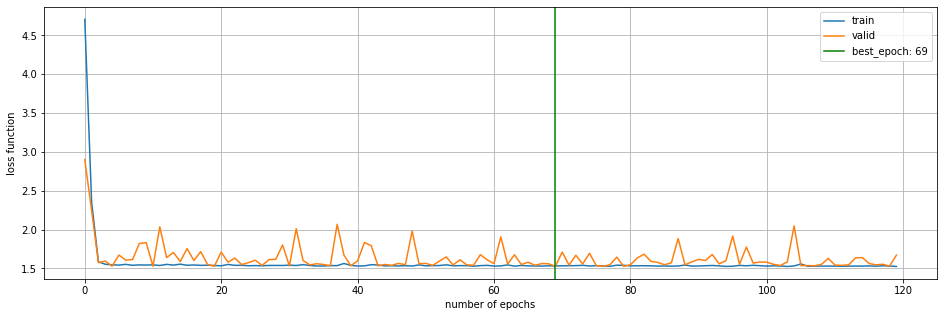

In [18]:
from utils.plot import plot_losses

plot_losses(train_loss_history, valid_loss_history, best_valid_score, burn_in=0)

# prediction

In [19]:
df_pred = pd.DataFrame({
    **{f"target_{i}": y_test[:,i] for i in range(y_test.shape[1])}
})
df_pred.head(1)

,target_0,target_1
0,26.902728,-6.843365


In [20]:
x_test_tensor = torch.from_numpy(x_test).float()
x_test_tensor.shape

torch.Size([29017, 3])

In [21]:
model.eval()

outputs = model(x_test_tensor)
outputs = outputs.detach().numpy()

for i in range(outputs.shape[1]):
    df_pred[f"pred_after_train_{i}"] = outputs[:, i]

In [22]:
model_test = MultipleOutputModel.load(model_path)
model_test.eval()

outputs_test = model_test(x_test_tensor)
outputs_test = outputs_test.detach().numpy()

for i in range(outputs_test.shape[1]):
    df_pred[f"pred_after_load_{i}"] = outputs_test[:, i]

Loaded model from: ../models/multiple_outputs_model_checkpoint.pth


In [23]:
df_pred.head()

,target_0,target_1,pred_after_train_0,pred_after_train_1,pred_after_load_0,pred_after_load_1
0,26.902728,-6.843365,25.802752,-3.897906,26.728991,-3.599747
1,19.918566,-17.885354,19.199432,-15.353830,19.938971,-14.979001
2,16.461923,-13.012003,15.477965,-16.139208,16.288353,-15.974180
3,22.146175,-16.947079,21.292152,-13.937381,22.128319,-13.711980
4,24.324802,-7.333342,23.765053,-8.569138,24.287800,-8.351547


In [24]:
print(np.abs(df_pred["target_0"] - df_pred["pred_after_train_0"]).mean())
print(np.abs(df_pred["target_0"] - df_pred["pred_after_load_0"]).mean())

1.0164490165627864
0.8064048869278801


In [25]:
print(np.abs(df_pred["target_1"] - df_pred["pred_after_train_1"]).mean())
print(np.abs(df_pred["target_1"] - df_pred["pred_after_load_1"]).mean())

3.1996028302565565
3.2071064473611224


In [26]:
%%javascript
IPython.notebook.save_notebook()
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [28]:
!jupyter nbconvert --to html $nb_name

[NbConvertApp] Converting notebook 04_multiple_outputs.ipynb to html
[NbConvertApp] Writing 418187 bytes to 04_multiple_outputs.html
